## Interactively install packages as needed

The below cells show how to install/upgrade packages on the cluster using pip, interactively. No kernel restart needed.

In [1]:
import os
import dask
from dask.distributed import Client
from azureml.core import Run

In [2]:
packages = 'matplotlib dask-lightgbm'

def update_packages(packages):
    os.system(f'pip install --upgrade {packages}')

In [3]:
try:
    run = Run.get_context()
except:
    print('Not in a run -- follow link from the cluster widget')

In [4]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.0.0.5:8786 Dashboard: http://10.0.0.5:8787/status,Cluster Workers: 25 Cores: 200 Memory: 1.48 TB


In [5]:
nodes = 25

to_compute = dask.delayed([dask.delayed(update_packages)(packages) for i in range(nodes)])
to_compute.compute();

In [6]:
c.restart()

Client Scheduler: tcp://10.0.0.5:8786 Dashboard: http://10.0.0.5:8787/status,Cluster Workers: 25 Cores: 200 Memory: 1.48 TB


## Connect to cluster

In [7]:
import os
import glob
import dask
import time
import joblib
import fsspec
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML
from dask_ml.xgboost import XGBRegressor

from azureml.core import Run, Model

%matplotlib inline

In [8]:
try:
    run = Run.get_context()
except:
    print('Not in a run -- follow link from the cluster widget')
    
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-cloudprovider,dask-cloudprovider_1584230495_d0acb81c,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [9]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.0.0.5:8786 Dashboard: http://10.0.0.5:8787/status,Cluster Workers: 25 Cores: 200 Memory: 1.48 TB


## Read data

Conveniently, the datastore is mounted so it can be viewed/operated on as if local. However, for reading into the distributed cluster, we will use ADLS's HDFS driver.

In [10]:
STORAGE_OPTIONS = {
    'account_name': run.experiment.workspace.get_default_datastore().account_name,
    'account_key' : run.experiment.workspace.get_default_datastore().account_key
}

protocol  = 'abfs'      # change to 'adl' for gen 1
container = run.experiment.workspace.get_default_datastore().container_name

In [11]:
fs = fsspec.filesystem(protocol, **STORAGE_OPTIONS)

In [12]:
files = fs.glob(f'{container}/noaa-isd/year=*/month=*/*.parquet') # adjust size of data if needed
files = [f'{protocol}://{file}' for file in files]  
files[-5:]

['abfs://azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd/year=2020/month=3/part-00003-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1967-3.c000.snappy.parquet',
 'abfs://azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd/year=2020/month=3/part-00004-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1972-3.c000.snappy.parquet',
 'abfs://azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd/year=2020/month=3/part-00005-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1965-3.c000.snappy.parquet',
 'abfs://azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd/year=2020/month=3/part-00006-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1971-3.c000.snappy.parquet',
 'abfs://azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd/year=2020/month=3/part-00007-tid-3885831618057415937-9715e54c-7a20-4936-96e9-5938bd33d1d0-1966-3.c000.snappy.parquet']

In [13]:
df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).repartition(npartitions=200).persist()
%time df.head()

CPU times: user 348 ms, sys: 21.9 ms, total: 370 ms
Wall time: 2min


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,53878,2008-01-10 18:30:00,35.419,-82.557,641.0,NaN,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,10,1.0
1,999999,53877,2008-01-06 13:45:00,35.495,-82.614,656.0,NaN,NaN,1.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 8 SSW,US,999999-53877,2008,6,1.0
2,999999,53878,2008-01-29 14:35:00,35.419,-82.557,641.0,NaN,NaN,7.3,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,29,1.0
3,999999,53877,2008-01-04 05:25:00,35.495,-82.614,656.0,NaN,NaN,-11.4,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 8 SSW,US,999999-53877,2008,4,1.0
4,999999,53878,2008-01-12 00:30:00,35.419,-82.557,641.0,NaN,NaN,5.7,NaN,...,NaN,NaN,NaN,NaN,ASHEVILLE 13 S,US,999999-53878,2008,12,1.0


In [14]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=True).persist()
%time len(df)

/azureml-envs/azureml_dc47200d9b15811b70e3679097613f52/lib/python3.6/site-packages/dask/dataframe/shuffle.py:746: UserWarning: Partition indices have overlap.
  warnings.warn("Partition indices have overlap.")


CPU times: user 415 ms, sys: 39.2 ms, total: 454 ms
Wall time: 2min 18s


1431948995

In [15]:
%time len(df)

CPU times: user 121 ms, sys: 7.98 ms, total: 129 ms
Wall time: 325 ms


1431948995

## Explore data

In [16]:
%time df.describe().compute()

CPU times: user 11.1 s, sys: 240 ms, total: 11.4 s
Wall time: 2min 12s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.431949e+09,1.431949e+09,1.431949e+09,1.148350e+09,1.192570e+09,1.405009e+09,5.094581e+08,1.297105e+08,5.320770e+07,3.014339e+08,3.014339e+08,8.394657e+06,1.431949e+09,1.431949e+09,1.431949e+09
mean,3.742744e+01,-3.946612e+01,3.976599e+02,1.651899e+02,3.439403e+00,1.187728e+01,1.014680e+03,2.980657e+01,4.259895e+00,9.453508e+00,1.086173e+03,1.810708e+01,2.013900e+03,1.569345e+01,1.000000e+00
std,2.157934e+01,7.853901e+01,6.275807e+02,1.145395e+02,2.869667e+00,1.251185e+01,9.408058e+00,2.930769e+01,3.001570e+00,2.041014e+01,3.097014e+03,3.329559e+01,3.474673e+00,8.814658e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.524200e+01,4.600000e+01,9.000000e+01,2.000000e+00,8.400000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.112400e+01,2.010000e+02,1.900000e+02,3.600000e+00,1.600000e+01,1.017200e+03,5.000000e+01,5.000000e+00,3.000000e+00,0.000000e+00,1.500000e+01,2.016000e+03,1.600000e+01,1.000000e+00
75%,4.917300e+01,1.750000e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.740000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.200000e+01,2.020000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.020000e+03,3.100000e+01,1.000000e+00


In [17]:
%time places = df.groupby(df.index)[['longitude', 'latitude', 'year']].mean().compute()

CPU times: user 268 ms, sys: 4.15 ms, total: 272 ms
Wall time: 10.2 s


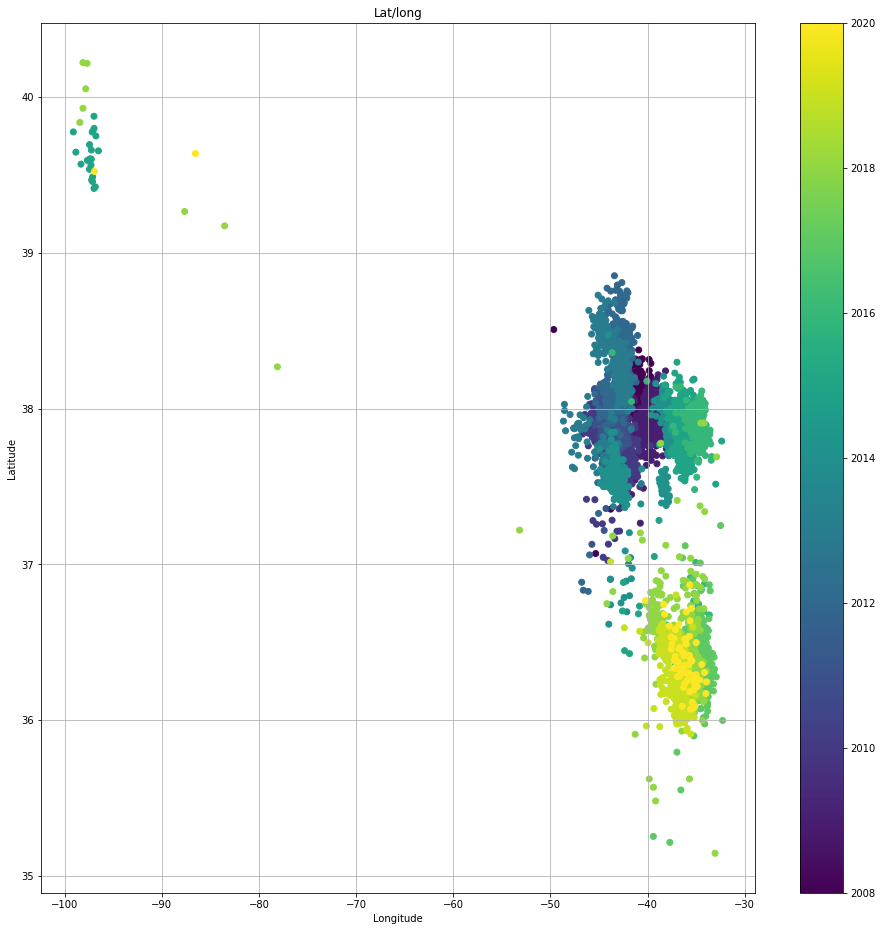

In [18]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

#run.log_image(f'lat_long', plot=plt) # log image to run

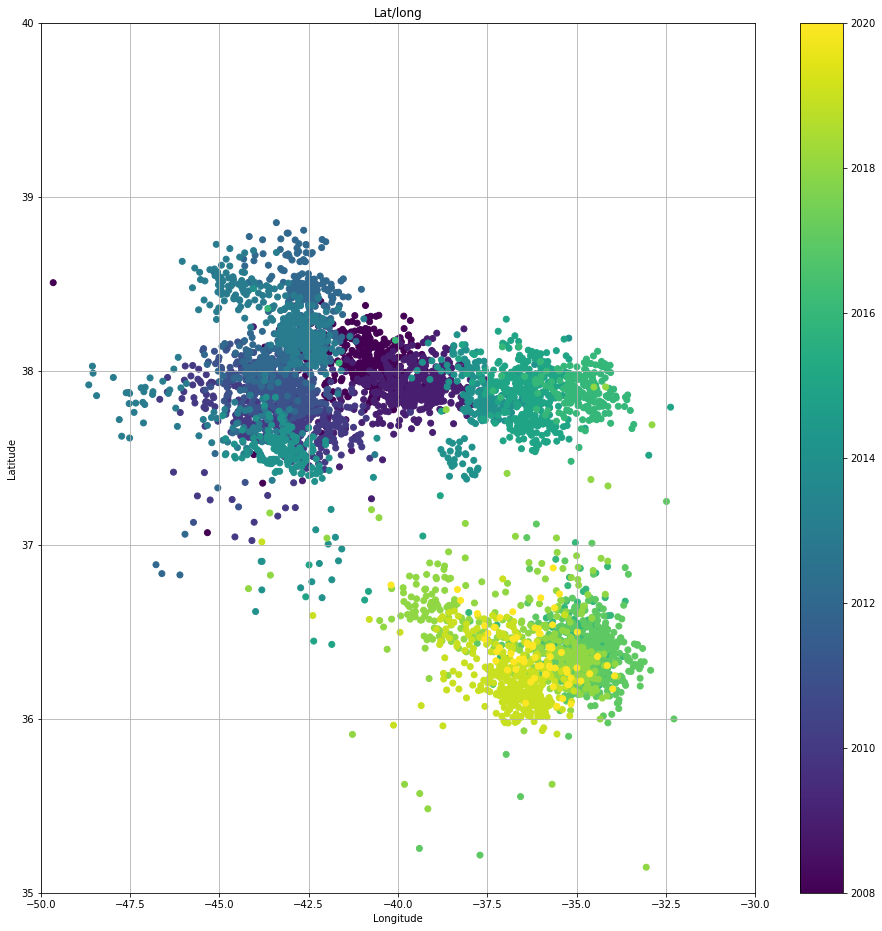

In [19]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30]) # zoom in 
plt.ylim([35, 40])   # zoom in 
plt.grid()
plt.colorbar()

run.log_image(f'lat_long_zoomed', plot=plt) # log image to run 

In [20]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 406 ms, sys: 22.9 ms, total: 429 ms
Wall time: 1min 29s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


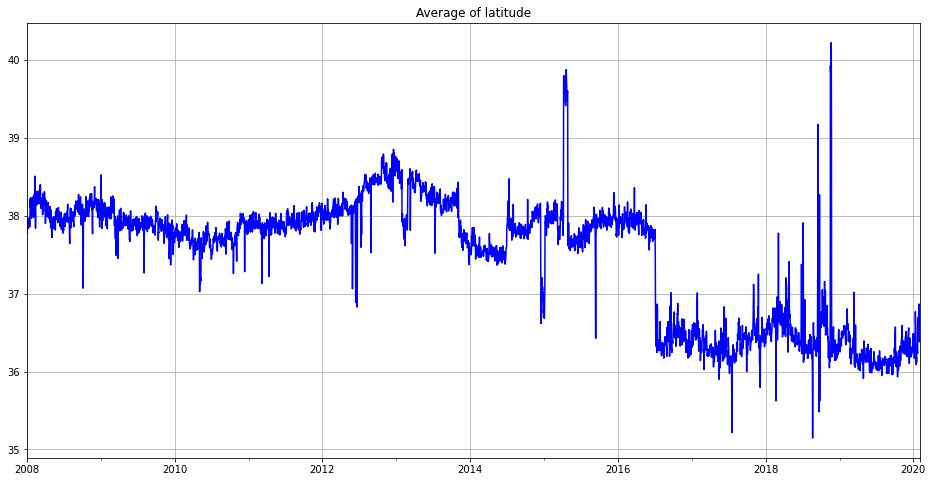

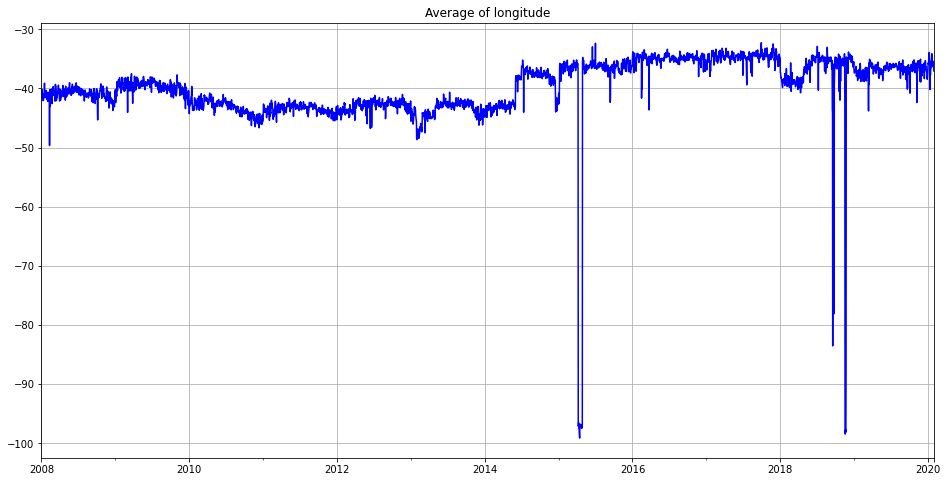

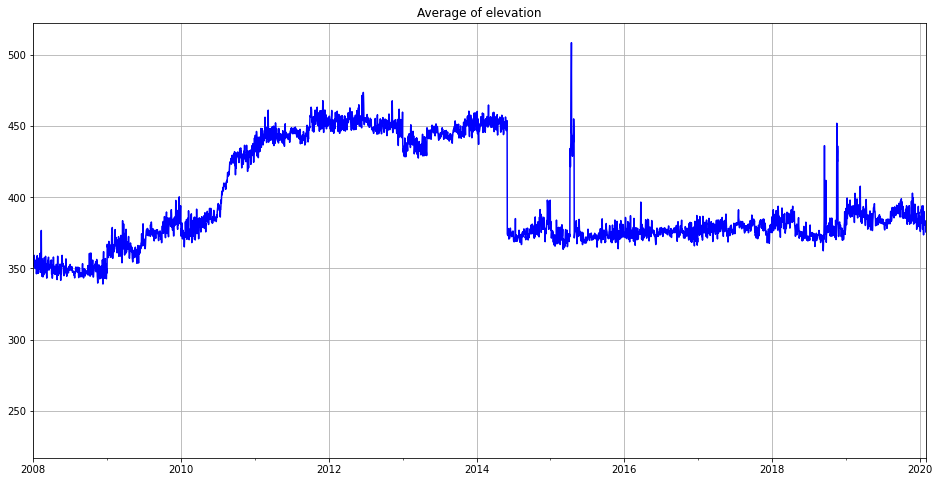

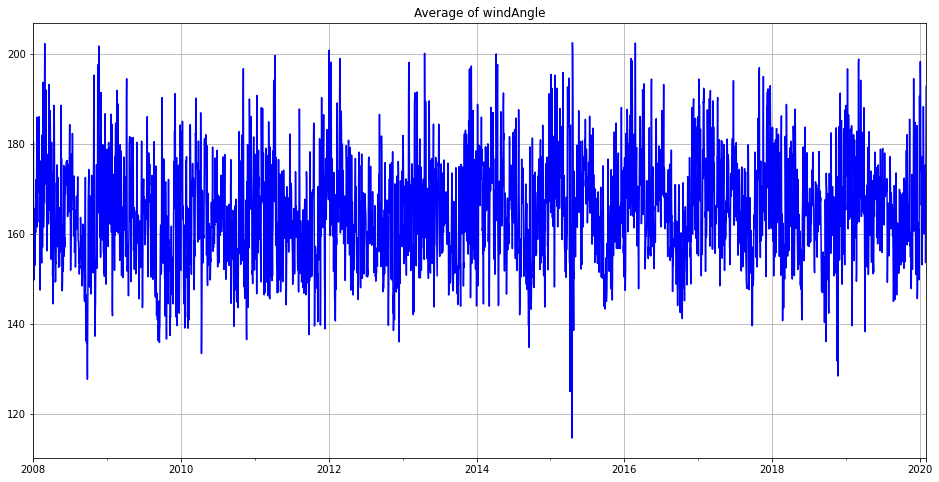

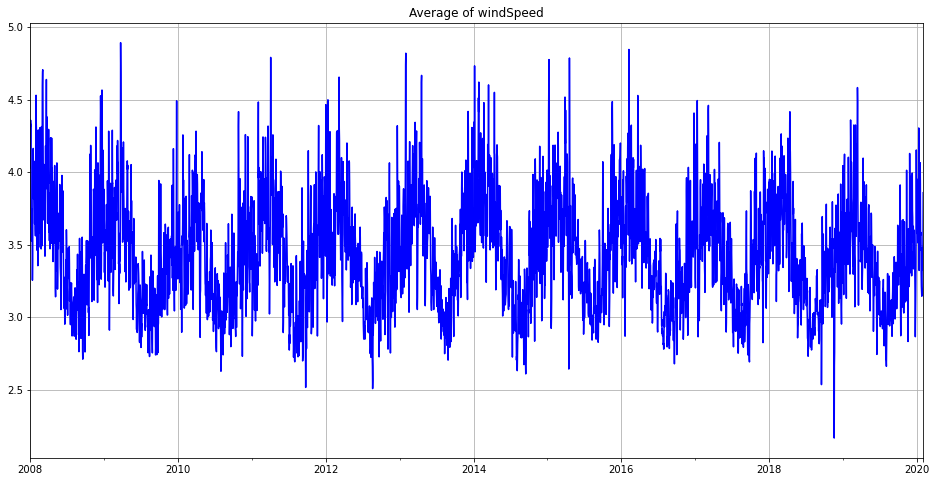

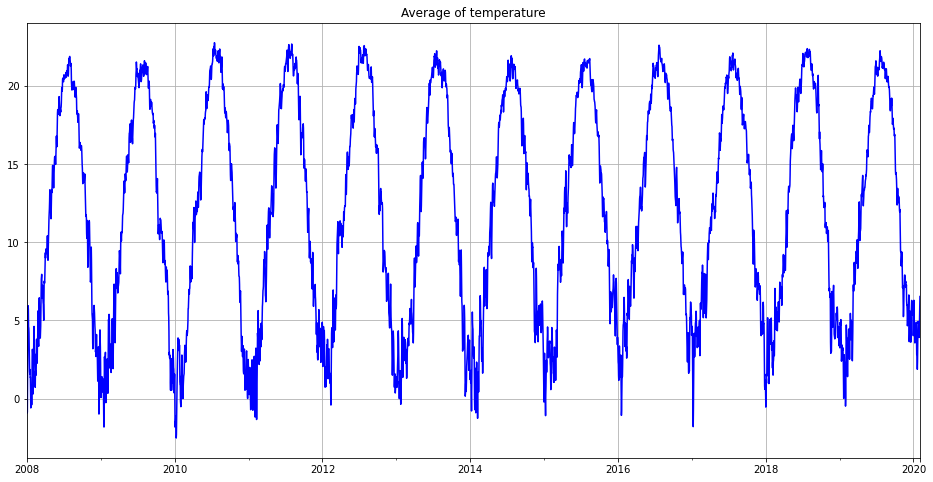

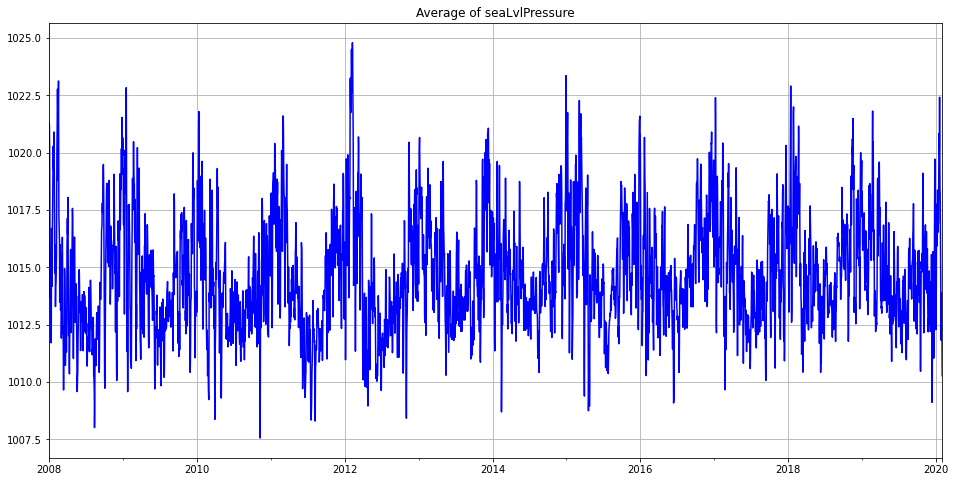

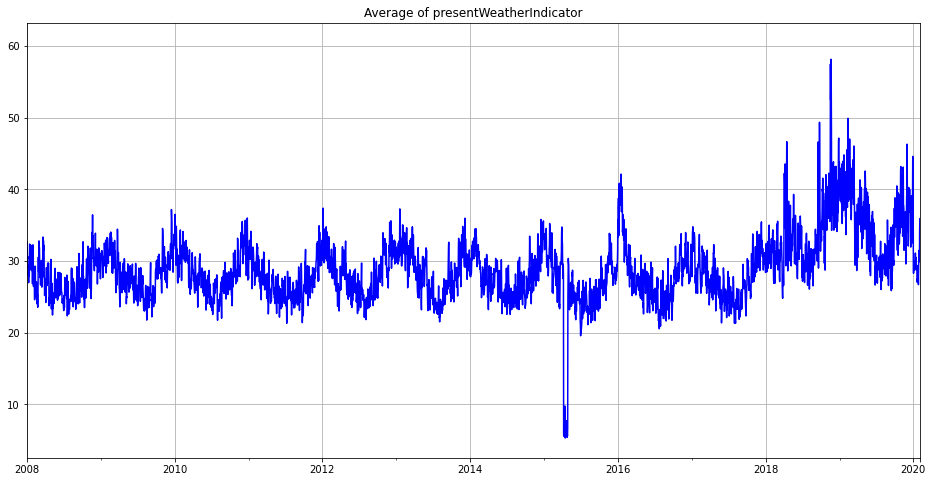

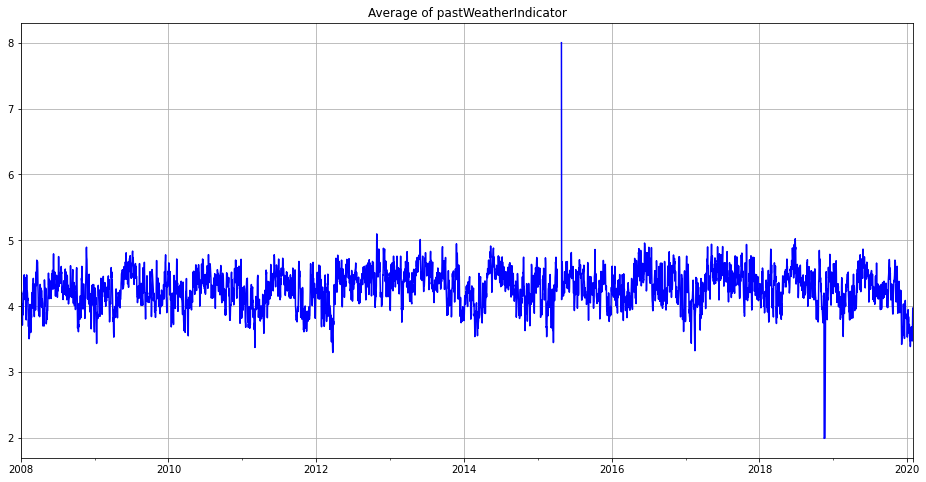

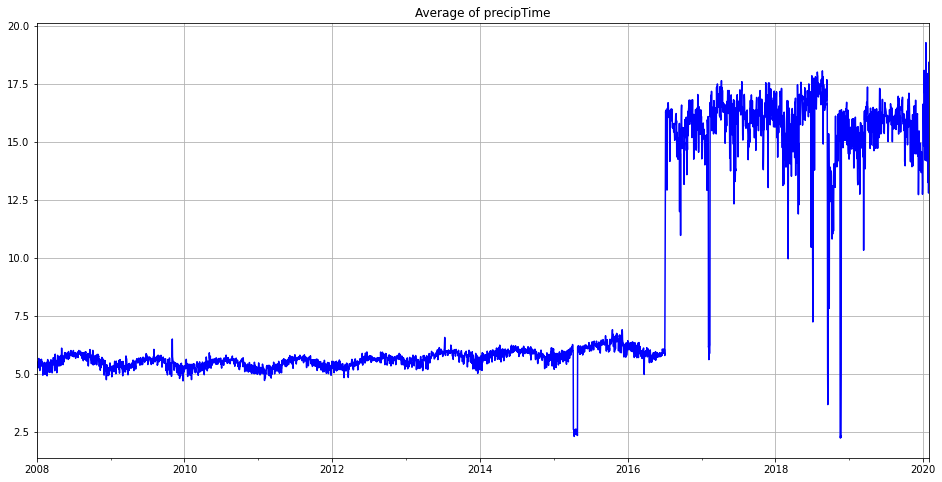

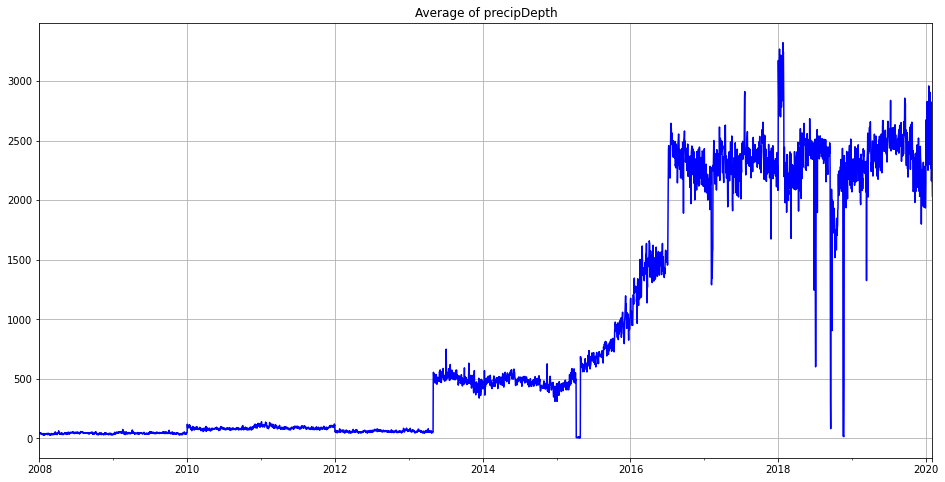

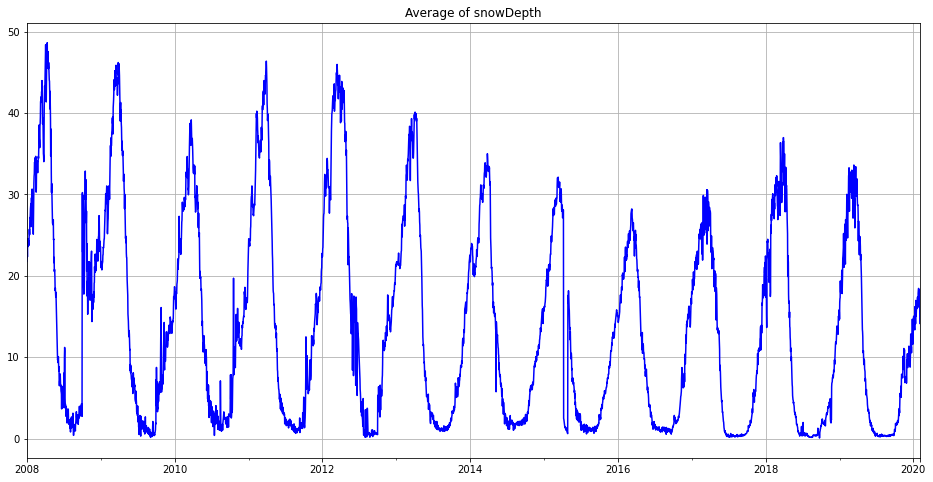

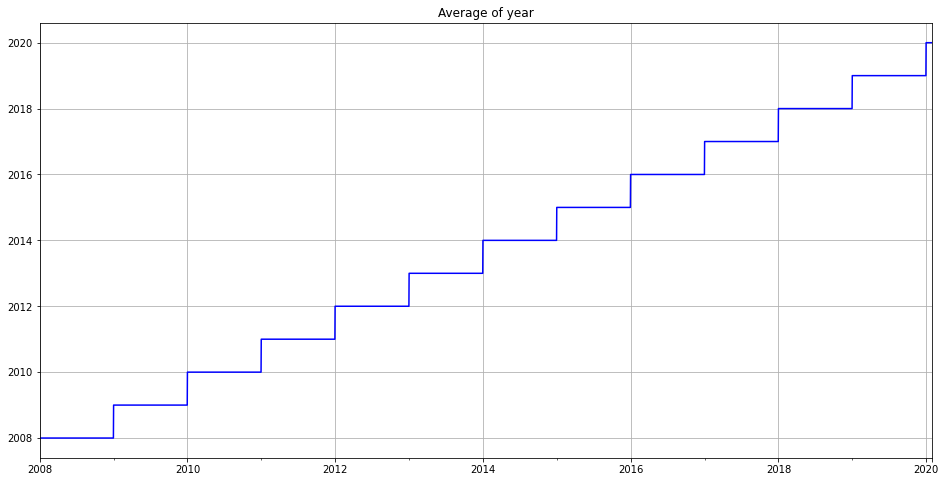

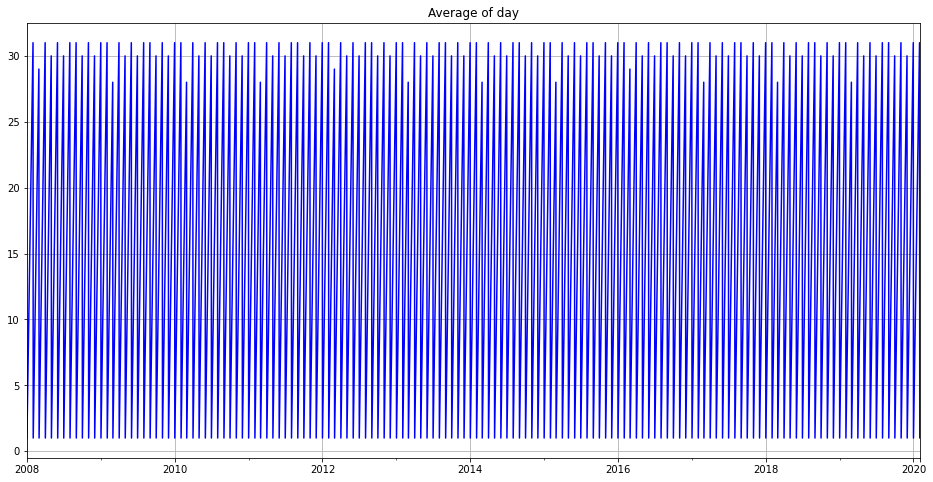

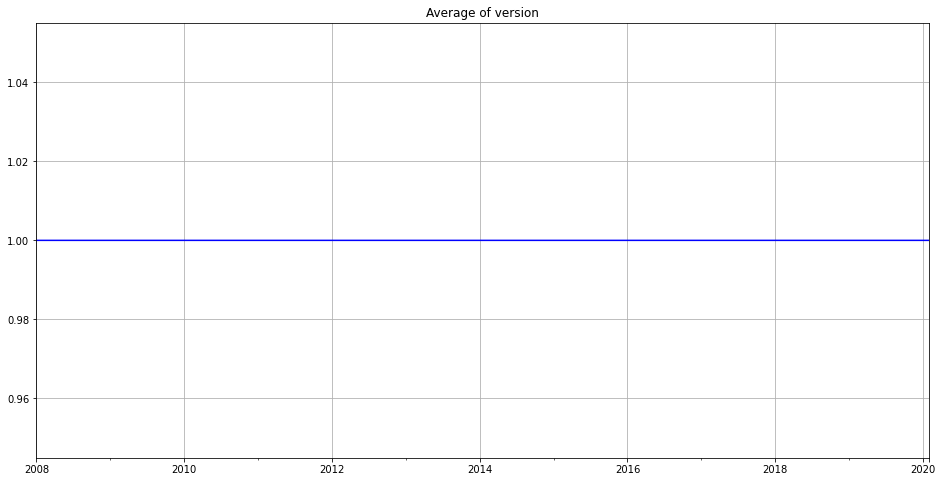

In [21]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2020, 2, 1)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [22]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-cloudprovider,dask-cloudprovider_1584230495_d0acb81c,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Transform data

In [23]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

## Write data

**Warning**: This will write >150 GB of CSV files to your default storage account. 

In [24]:
#%time df.to_csv(f'{protocol}://{container}/noaa-isd-csv/part-*-data.csv', storage_options=STORAGE_OPTIONS)

CPU times: user 3.94 s, sys: 364 ms, total: 4.31 s
Wall time: 28min 25s


['azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-000-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-001-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-002-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-003-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-004-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-005-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-006-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-007-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-008-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-009-data.csv',
 'azureml-blobstore-9e43fe7d-d3a9-43d4-aab1-872485cdf54b/noaa-isd-csv/part-010-data.csv',
 'azureml-

## Take subset of data to Pandas

In [25]:
%time df2 = df[df['stationName'].str.contains('FLORIDA|WASHINGTON|TEXAS', regex=True, na=False)].compute()
df2

CPU times: user 1.95 s, sys: 633 ms, total: 2.59 s
Wall time: 1min 43s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
2008-01-04,725454,04903,2008-01-04 10:35:00,41.276,-91.667,230.0,200.0,6.7,28.40,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,4,1.0
2008-01-26,725454,04903,2008-01-26 04:15:00,41.276,-91.667,230.0,170.0,4.6,26.60,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,26,1.0
2008-01-08,725454,04903,2008-01-08 05:59:00,41.276,-91.667,230.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,8,1.0
2008-01-20,725454,04903,2008-01-20 02:35:00,41.276,-91.667,230.0,270.0,2.6,-0.40,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,20,1.0
2008-01-30,725454,04903,2008-01-30 22:15:00,41.276,-91.667,230.0,80.0,1.5,14.00,NaN,...,NaN,NaN,NaN,NaN,WASHINGTON MUNICIPAL ARPT,US,725454-04903,2008,30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-04,998490,99999,2020-03-04 00:00:00,29.689,-93.842,11.0,80.0,3.6,65.66,1007.0,...,NaN,NaN,NaN,NaN,TEXAS POINT,US,998490-99999,2020,4,1.0
2020-03-01,998490,99999,2020-03-01 03:00:00,29.689,-93.842,11.0,150.0,5.7,60.98,1021.3,...,NaN,NaN,NaN,NaN,TEXAS POINT,US,998490-99999,2020,1,1.0
2020-03-04,998490,99999,2020-03-04 21:00:00,29.689,-93.842,11.0,260.0,2.1,67.28,1005.1,...,NaN,NaN,NaN,NaN,TEXAS POINT,US,998490-99999,2020,4,1.0
2020-03-02,998490,99999,2020-03-02 08:00:00,29.689,-93.842,11.0,170.0,5.1,62.96,1011.4,...,NaN,NaN,NaN,NaN,TEXAS POINT,US,998490-99999,2020,2,1.0


In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2810475 entries, 2008-01-04 to 2020-03-07
Data columns (total 22 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   usaf                     object        
 1   wban                     object        
 2   datetime                 datetime64[ns]
 3   latitude                 float64       
 4   longitude                float64       
 5   elevation                float64       
 6   windAngle                float64       
 7   windSpeed                float64       
 8   temperature              float64       
 9   seaLvlPressure           float64       
 10  cloudCoverage            object        
 11  presentWeatherIndicator  float64       
 12  pastWeatherIndicator     float64       
 13  precipTime               float64       
 14  precipDepth              float64       
 15  snowDepth                float64       
 16  stationName              object        
 17  countryOrReg

## Train XGBoost model

The below cells are for demo purposes only. The code is not good. The data science is not good. 

In [27]:
# begin data prep for ML 
df = df.fillna(0)

In [28]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

['latitude',
 'longitude',
 'elevation',
 'windAngle',
 'windSpeed',
 'temperature',
 'seaLvlPressure',
 'presentWeatherIndicator',
 'pastWeatherIndicator',
 'precipTime',
 'precipDepth',
 'snowDepth',
 'year',
 'day']

In [29]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep for ML

In [30]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

CPU times: user 2.57 s, sys: 235 ms, total: 2.8 s
Wall time: 16min 35s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=16, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [31]:
%time y_pred = xgb.predict(X).compute()

CPU times: user 6.15 s, sys: 4.09 s, total: 10.2 s
Wall time: 27.1 s


In [32]:
rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5 # runs locally, distribute (?)
run.log('RMSE', rmse)
print(f'Training RMSE: {round(rmse, 3)}')

Training RMSE: 17.453


## Register model

In [33]:
model_path = 'xgboost_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path)
xgb = joblib.load(model_path)

In [34]:
model = Model.register(run.experiment.workspace, 
                       model_name      = 'xgboost-noaa-isd', 
                       model_path      = model_path,
                       description     = 'Dask XGBoost NOAA ISD temperature predictor',
                       model_framework = 'DaskML.XGBoostRegressor')

Registering model xgboost-noaa-isd
